In [1]:
import os
import torch
import torch.nn as nn
import torch

import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
import dycomutils
from sentence_transformers import SentenceTransformer
import pandas as pd
import torch.nn.functional as F
import math


import os
import numpy as np
import matplotlib.pyplot as plt
import neptune
from dotenv import load_dotenv
import dycomutils
plt.rcParams.update({'font.size': 24})

import warnings
warnings.filterwarnings('ignore')

# Torch
import torch
import torchaudio
#from torch.utils import tensorboard
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from typing import Tuple, List
from tqdm import tqdm

# Load Configs
load_dotenv()
cuda = True if torch.cuda.is_available() else False

# run = neptune.init_run(
#     project="Botz/Audio-MI",
#     name="sinc-net-training",
#     api_token=os.getenv("NEPTUNE_API_TOKEN")
# )

In [2]:
def flip(x, dim):
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.contiguous()
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1, 
                      -1, -1), ('cpu','cuda')[x.is_cuda])().long(), :]
    return x.view(xsize)


def sinc(band,t_right):
    y_right= torch.sin(2*math.pi*band*t_right)/(2*math.pi*band*t_right)
    y_left= flip(y_right,0)

    y=torch.cat([y_left,Variable(torch.ones(1)).cuda(),y_right])

    return y
    

class SincConv_fast(nn.Module):
    """Sinc-based convolution
    Parameters
    ----------
    in_channels : `int`
        Number of input channels. Must be 1.
    out_channels : `int`
        Number of filters.
    kernel_size : `int`
        Filter length.
    sample_rate : `int`, optional
        Sample rate. Defaults to 16000.
    Usage
    -----
    See `torch.nn.Conv1d`
    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    """

    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1, min_low_hz=50, min_band_hz=50):

        super(SincConv_fast,self).__init__()

        if in_channels != 1:
            #msg = (f'SincConv only support one input channel '
            #       f'(here, in_channels = {in_channels:d}).')
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1
            
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = 30
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.out_channels + 1)
        hz = self.to_hz(mel)
        

        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

        # Hamming window
        #self.window_ = torch.hamming_window(self.kernel_size)
        n_lin=torch.linspace(0, (self.kernel_size/2)-1, steps=int((self.kernel_size/2))) # computing only half of the window
        self.window_=0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size);


        # (1, kernel_size/2)
        n = (self.kernel_size - 1) / 2.0
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate # Due to symmetry, I only need half of the time axes

 


    def forward(self, waveforms):
        """
        Parameters
        ----------
        waveforms : `torch.Tensor` (batch_size, 1, n_samples)
            Batch of waveforms.
        Returns
        -------
        features : `torch.Tensor` (batch_size, out_channels, n_samples_out)
            Batch of sinc filters activations.
        """

        self.n_ = self.n_.to(waveforms.device)

        self.window_ = self.window_.to(waveforms.device)

        low = self.min_low_hz  + torch.abs(self.low_hz_)
        
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_),self.min_low_hz,self.sample_rate/2)
        band=(high-low)[:,0]
        
        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        band_pass_left=((torch.sin(f_times_t_high)-torch.sin(f_times_t_low))/(self.n_/2))*self.window_ # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET). I just have expanded the sinc and simplified the terms. This way I avoid several useless computations. 
        band_pass_center = 2*band.view(-1,1)
        band_pass_right= torch.flip(band_pass_left,dims=[1])
        
        
        band_pass=torch.cat([band_pass_left,band_pass_center,band_pass_right],dim=1)

        
        band_pass = band_pass / (2*band[:,None])
        

        self.filters = (band_pass).view(
            self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1) 


        
        
class sinc_conv(nn.Module):

    def __init__(self, N_filt,Filt_dim,fs):
        super(sinc_conv,self).__init__()

        # Mel Initialization of the filterbanks
        low_freq_mel = 80
        high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, N_filt)  # Equally spaced in Mel scale
        f_cos = (700 * (10**(mel_points / 2595) - 1)) # Convert Mel to Hz
        b1=np.roll(f_cos,1)
        b2=np.roll(f_cos,-1)
        b1[0]=30
        b2[-1]=(fs/2)-100
                
        self.freq_scale=fs*1.0
        self.filt_b1 = nn.Parameter(torch.from_numpy(b1/self.freq_scale))
        self.filt_band = nn.Parameter(torch.from_numpy((b2-b1)/self.freq_scale))

        
        self.N_filt=N_filt
        self.Filt_dim=Filt_dim
        self.fs=fs
        

    def forward(self, x):
        
        filters=Variable(torch.zeros((self.N_filt,self.Filt_dim))).cuda()
        N=self.Filt_dim
        t_right=Variable(torch.linspace(1, (N-1)/2, steps=int((N-1)/2))/self.fs).cuda()
        
        
        min_freq=50.0;
        min_band=50.0;
        
        filt_beg_freq=torch.abs(self.filt_b1)+min_freq/self.freq_scale
        filt_end_freq=filt_beg_freq+(torch.abs(self.filt_band)+min_band/self.freq_scale)
       
        n=torch.linspace(0, N, steps=N)

        # Filter window (hamming)
        window=0.54-0.46*torch.cos(2*math.pi*n/N);
        window=Variable(window.float().cuda())

        
        for i in range(self.N_filt):
                        
            low_pass1 = 2*filt_beg_freq[i].float()*sinc(filt_beg_freq[i].float()*self.freq_scale,t_right)
            low_pass2 = 2*filt_end_freq[i].float()*sinc(filt_end_freq[i].float()*self.freq_scale,t_right)
            band_pass=(low_pass2-low_pass1)

            band_pass=band_pass/torch.max(band_pass)

            filters[i,:]=band_pass.cuda()*window

        out=F.conv1d(x, filters.view(self.N_filt,1,self.Filt_dim))
    
        return out
    

def act_fun(act_type):

 if act_type=="relu":
    return nn.ReLU()
            
 if act_type=="tanh":
    return nn.Tanh()
            
 if act_type=="sigmoid":
    return nn.Sigmoid()
           
 if act_type=="leaky_relu":
    return nn.LeakyReLU(0.2)
            
 if act_type=="elu":
    return nn.ELU()
                     
 if act_type=="softmax":
    return nn.LogSoftmax(dim=1)
        
 if act_type=="linear":
    return nn.LeakyReLU(1) # initializzed like this, but not used in forward!
            
            
class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


class MLP(nn.Module):
    def __init__(self, options):
        super(MLP, self).__init__()
        
        self.input_dim=int(options['input_dim'])
        self.fc_lay=options['fc_lay']
        self.fc_drop=options['fc_drop']
        self.fc_use_batchnorm=options['fc_use_batchnorm']
        self.fc_use_laynorm=options['fc_use_laynorm']
        self.fc_use_laynorm_inp=options['fc_use_laynorm_inp']
        self.fc_use_batchnorm_inp=options['fc_use_batchnorm_inp']
        self.fc_act=options['fc_act']
        
       
        self.wx  = nn.ModuleList([])
        self.bn  = nn.ModuleList([])
        self.ln  = nn.ModuleList([])
        self.act = nn.ModuleList([])
        self.drop = nn.ModuleList([])
       

       
        # input layer normalization
        if self.fc_use_laynorm_inp:
           self.ln0=LayerNorm(self.input_dim)
          
        # input batch normalization    
        if self.fc_use_batchnorm_inp:
           self.bn0=nn.BatchNorm1d([self.input_dim],momentum=0.05)
           
           
        self.N_fc_lay=len(self.fc_lay)
             
        current_input=self.input_dim
        
        # Initialization of hidden layers
        
        for i in range(self.N_fc_lay):
            
         # dropout
         self.drop.append(nn.Dropout(p=self.fc_drop[i]))
         
         # activation
         self.act.append(act_fun(self.fc_act[i]))
         
         
         add_bias=True
         
         # layer norm initialization
         self.ln.append(LayerNorm(self.fc_lay[i]))
         self.bn.append(nn.BatchNorm1d(self.fc_lay[i],momentum=0.05))
         
         if self.fc_use_laynorm[i] or self.fc_use_batchnorm[i]:
             add_bias=False
         
              
         # Linear operations
         self.wx.append(nn.Linear(current_input, self.fc_lay[i],bias=add_bias))
         
         # weight initialization
         self.wx[i].weight = torch.nn.Parameter(torch.Tensor(self.fc_lay[i],current_input).uniform_(-np.sqrt(0.01/(current_input+self.fc_lay[i])),np.sqrt(0.01/(current_input+self.fc_lay[i]))))
         self.wx[i].bias = torch.nn.Parameter(torch.zeros(self.fc_lay[i]))
         
         current_input=self.fc_lay[i]
         
         
    def forward(self, x):
        
      # Applying Layer/Batch Norm
      if bool(self.fc_use_laynorm_inp):
        x=self.ln0((x))
        
      if bool(self.fc_use_batchnorm_inp):
        x=self.bn0((x))
        
      for i in range(self.N_fc_lay):

        if self.fc_act[i]!='linear':
            
          if self.fc_use_laynorm[i]:
           x = self.drop[i](self.act[i](self.ln[i](self.wx[i](x))))
          
          if self.fc_use_batchnorm[i]:
           x = self.drop[i](self.act[i](self.bn[i](self.wx[i](x))))
          
          if self.fc_use_batchnorm[i]==False and self.fc_use_laynorm[i]==False:
           x = self.drop[i](self.act[i](self.wx[i](x)))
           
        else:
          if self.fc_use_laynorm[i]:
           x = self.drop[i](self.ln[i](self.wx[i](x)))
          
          if self.fc_use_batchnorm[i]:
           x = self.drop[i](self.bn[i](self.wx[i](x)))
          
          if self.fc_use_batchnorm[i]==False and self.fc_use_laynorm[i]==False:
           x = self.drop[i](self.wx[i](x)) 
          
      return x



class SincNet(nn.Module):
    
    def __init__(self,options):
       super(SincNet,self).__init__()
    
       self.cnn_N_filt=options['cnn_N_filt']
       self.cnn_len_filt=options['cnn_len_filt']
       self.cnn_max_pool_len=options['cnn_max_pool_len']
       
       
       self.cnn_act=options['cnn_act']
       self.cnn_drop=options['cnn_drop']
       
       self.cnn_use_laynorm=options['cnn_use_laynorm']
       self.cnn_use_batchnorm=options['cnn_use_batchnorm']
       self.cnn_use_laynorm_inp=options['cnn_use_laynorm_inp']
       self.cnn_use_batchnorm_inp=options['cnn_use_batchnorm_inp']
       
       self.input_dim=int(options['input_dim'])
       
       self.fs=options['fs']
       
       self.N_cnn_lay=len(options['cnn_N_filt'])
       self.conv  = nn.ModuleList([])
       self.bn  = nn.ModuleList([])
       self.ln  = nn.ModuleList([])
       self.act = nn.ModuleList([])
       self.drop = nn.ModuleList([])
       
             
       if self.cnn_use_laynorm_inp:
           self.ln0=LayerNorm(self.input_dim)
           
       if self.cnn_use_batchnorm_inp:
           self.bn0=nn.BatchNorm1d([self.input_dim],momentum=0.05)
           
       current_input=self.input_dim 
       
       for i in range(self.N_cnn_lay):
         
         N_filt=int(self.cnn_N_filt[i])
         len_filt=int(self.cnn_len_filt[i])
         
         # dropout
         self.drop.append(nn.Dropout(p=self.cnn_drop[i]))
         
         # activation
         self.act.append(act_fun(self.cnn_act[i]))
                    
         # layer norm initialization         
         self.ln.append(LayerNorm([N_filt,int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i])]))

         self.bn.append(nn.BatchNorm1d(N_filt,int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i]),momentum=0.05))
            

         if i==0:
          self.conv.append(SincConv_fast(self.cnn_N_filt[0],self.cnn_len_filt[0],self.fs))
              
         else:
          self.conv.append(nn.Conv1d(self.cnn_N_filt[i-1], self.cnn_N_filt[i], self.cnn_len_filt[i]))
          
         current_input=int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i])

         
       self.out_dim=current_input*N_filt



    def forward(self, x):
       batch=x.shape[0]
       seq_len=x.shape[1]
       
       if bool(self.cnn_use_laynorm_inp):
        x=self.ln0((x))
        
       if bool(self.cnn_use_batchnorm_inp):
        x=self.bn0((x))
        
       x=x.view(batch,1,seq_len)

       
       for i in range(self.N_cnn_lay):
           
         if self.cnn_use_laynorm[i]:
          if i==0:
           x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(torch.abs(self.conv[i](x)), self.cnn_max_pool_len[i]))))  
          else:
           x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(self.conv[i](x), self.cnn_max_pool_len[i]))))   
          
         if self.cnn_use_batchnorm[i]:
          x = self.drop[i](self.act[i](self.bn[i](F.max_pool1d(self.conv[i](x), self.cnn_max_pool_len[i]))))

         if self.cnn_use_batchnorm[i]==False and self.cnn_use_laynorm[i]==False:
          x = self.drop[i](self.act[i](F.max_pool1d(self.conv[i](x), self.cnn_max_pool_len[i])))

       
       x = x.view(batch,-1)

       return x
   
def str_to_bool(s):
    if s == 'True':
         return True
    elif s == 'False':
         return False
    else:
         raise ValueError 

    
   

In [3]:
RESAMPLE_RATE = 6000

fs=f"{RESAMPLE_RATE}"
cw_len="1024"
cw_shift="10"   

cnn_N_filt="100,80,80"
cnn_len_filt="251,5,5"
cnn_max_pool_len="3,3,3"
cnn_use_laynorm_inp="True"
cnn_use_batchnorm_inp="False"
cnn_use_laynorm="True,True,True"
cnn_use_batchnorm="False,False,False"
cnn_act="leaky_relu,leaky_relu,leaky_relu"
cnn_drop="0.1,0.1,0.1"


fc_lay="2048,2048,2048"
fc_drop="0.1,0.1,0.1"
fc_use_laynorm_inp="True"
fc_use_batchnorm_inp="False"
fc_use_batchnorm="True,True,True"
fc_use_laynorm="False,False,False"
fc_act="leaky_relu,leaky_relu,leaky_relu"

class_lay="2"
class_drop="0.0"
class_use_laynorm_inp="False"
class_use_batchnorm_inp="False"
class_use_batchnorm="False"
class_use_laynorm="False"
class_act="softmax"

lr="0.0004"
batch_size="128"
N_epochs="1500"
N_batches="800"
N_eval_epoch="8"
seed="1234"

# %%
cnn_N_filt=list(map(int, cnn_N_filt.split(',')))
cnn_len_filt=list(map(int, cnn_len_filt.split(',')))
cnn_max_pool_len=list(map(int, cnn_max_pool_len.split(',')))
cnn_use_laynorm_inp=str_to_bool(cnn_use_laynorm_inp)
cnn_use_batchnorm_inp=str_to_bool(cnn_use_batchnorm_inp)
cnn_use_laynorm=list(map(str_to_bool, cnn_use_laynorm.split(',')))
cnn_use_batchnorm=list(map(str_to_bool, cnn_use_batchnorm.split(',')))
cnn_act=list(map(str, cnn_act.split(',')))
cnn_drop=list(map(float, cnn_drop.split(',')))


#[dnn]
fc_lay=list(map(int, fc_lay.split(',')))
fc_drop=list(map(float, fc_drop.split(',')))
fc_use_laynorm_inp=str_to_bool(fc_use_laynorm_inp)
fc_use_batchnorm_inp=str_to_bool(fc_use_batchnorm_inp)
fc_use_batchnorm=list(map(str_to_bool, fc_use_batchnorm.split(',')))
fc_use_laynorm=list(map(str_to_bool, fc_use_laynorm.split(',')))
fc_act=list(map(str, fc_act.split(',')))

#[class]
class_lay=list(map(int, class_lay.split(',')))
class_drop=list(map(float, class_drop.split(',')))
class_use_laynorm_inp=str_to_bool(class_use_laynorm_inp)
class_use_batchnorm_inp=str_to_bool(class_use_batchnorm_inp)
class_use_batchnorm=list(map(str_to_bool, class_use_batchnorm.split(',')))
class_use_laynorm=list(map(str_to_bool, class_use_laynorm.split(',')))
class_act=list(map(str, class_act.split(',')))

In [4]:
wlen = 4000

In [5]:
# %%
# Feature extractor CNN
CNN_arch = {
    'input_dim': wlen,
    'fs': int(fs),
    'cnn_N_filt': cnn_N_filt,
    'cnn_len_filt': cnn_len_filt,
    'cnn_max_pool_len':cnn_max_pool_len,
    'cnn_use_laynorm_inp': cnn_use_laynorm_inp,
    'cnn_use_batchnorm_inp': cnn_use_batchnorm_inp,
    'cnn_use_laynorm':cnn_use_laynorm,
    'cnn_use_batchnorm':cnn_use_batchnorm,
    'cnn_act': cnn_act,
    'cnn_drop':cnn_drop,          
}


CNN_net=SincNet(CNN_arch)
CNN_net.cuda()



DNN1_arch = {
    'input_dim': CNN_net.out_dim,
    'fc_lay': fc_lay,
    'fc_drop': fc_drop, 
    'fc_use_batchnorm': fc_use_batchnorm,
    'fc_use_laynorm': fc_use_laynorm,
    'fc_use_laynorm_inp': fc_use_laynorm_inp,
    'fc_use_batchnorm_inp':fc_use_batchnorm_inp,
    'fc_act': fc_act,
}

DNN1_net=MLP(DNN1_arch)
DNN1_net.cuda()


DNN2_arch = {'input_dim':fc_lay[-1] ,
          'fc_lay': class_lay,
          'fc_drop': class_drop, 
          'fc_use_batchnorm': class_use_batchnorm,
          'fc_use_laynorm': class_use_laynorm,
          'fc_use_laynorm_inp': class_use_laynorm_inp,
          'fc_use_batchnorm_inp':class_use_batchnorm_inp,
          'fc_act': class_act,
          }


DNN2_net=MLP(DNN2_arch)
DNN2_net.cuda()

# %%
inp = torch.randn(2,  wlen).cuda()
out1 = CNN_net(inp)
print(out1.shape)

print(CNN_net.out_dim)
out2 = DNN1_net(out1)
print(out2.shape)

# %%
pout=DNN2_net(DNN1_net(CNN_net(inp)))
print(pout.shape)

torch.Size([2, 10960])
10960
torch.Size([2, 2048])
torch.Size([2, 2])


In [6]:
class FullSincNet(nn.Module):
    def __init__(self, num_class, fs=6000, wlen=4000):
        super(FullSincNet, self).__init__()
        # %%
        # Feature extractor CNN
        self.CNN_arch = {
            'input_dim': wlen,
            'fs': int(fs),
            'cnn_N_filt': cnn_N_filt,
            'cnn_len_filt': cnn_len_filt,
            'cnn_max_pool_len':cnn_max_pool_len,
            'cnn_use_laynorm_inp': cnn_use_laynorm_inp,
            'cnn_use_batchnorm_inp': cnn_use_batchnorm_inp,
            'cnn_use_laynorm':cnn_use_laynorm,
            'cnn_use_batchnorm':cnn_use_batchnorm,
            'cnn_act': cnn_act,
            'cnn_drop':cnn_drop,          
        }


        self.CNN_net = SincNet(self.CNN_arch)



        self.DNN1_arch = {
            'input_dim': self.CNN_net.out_dim,
            'fc_lay': fc_lay,
            'fc_drop': fc_drop, 
            'fc_use_batchnorm': fc_use_batchnorm,
            'fc_use_laynorm': fc_use_laynorm,
            'fc_use_laynorm_inp': fc_use_laynorm_inp,
            'fc_use_batchnorm_inp':fc_use_batchnorm_inp,
            'fc_act': fc_act,
        }

        self.DNN1_net=MLP(self.DNN1_arch)


        self.DNN2_arch = {'input_dim':fc_lay[-1] ,
                'fc_lay': [num_class],
                'fc_drop': class_drop, 
                'fc_use_batchnorm': class_use_batchnorm,
                'fc_use_laynorm': class_use_laynorm,
                'fc_use_laynorm_inp': class_use_laynorm_inp,
                'fc_use_batchnorm_inp':class_use_batchnorm_inp,
                'fc_act': class_act,
                }


        self.DNN2_net=MLP(self.DNN2_arch)

    def set_weights(self,weights_path):
        
        _weights = torch.load(weights_path, weights_only=False)
        self.CNN_net.load_state_dict(_weights['CNN_net'])
        self.DNN1_net.load_state_dict(_weights['DNN1_net'])
        self.DNN2_net.load_state_dict(_weights['DNN2_net'])
        
        self.id_map = _weights['speaker_to_id_map']

    def forward(self, x):
        x = self.CNN_net(x)
        x = self.DNN1_net(x)
        x = self.DNN2_net(x)
        return x

In [7]:
gender_classfier = FullSincNet(num_class=2)
age_classfier = FullSincNet(num_class=3)
accent_classfier = FullSincNet(num_class=11)

In [8]:
gender_classfier.set_weights("/home/desild/work/academic/sem3/TrustworthyML-assignment/tacotron2/vctk/models/SINCNET_GENDER/20251129_160107/checkpoint.pth")
age_classfier.set_weights("/home/desild/work/academic/sem3/TrustworthyML-assignment/tacotron2/vctk/models/SINCNET_AGEg/20251129_184806/checkpoint.pth")
accent_classfier.set_weights("/home/desild/work/academic/sem3/TrustworthyML-assignment/tacotron2/vctk/models/SINCNET_ACCENTS/20251129_173841/checkpoint.pth")

In [9]:
gender_classfier.cuda()
age_classfier.cuda()
accent_classfier.cuda()

gender_classfier.eval()
age_classfier.eval()
accent_classfier.eval();

In [10]:
sr_weights = torch.load("/home/desild/work/academic/sem3/TrustworthyML-assignment/tacotron2/vctk/models/SINCNET_SR/20251129_142613/checkpoint.pth", weights_only=False)

In [11]:
speaker_ids = sr_weights['speaker_to_id_map']

id2speaker = {v: int(k) for k, v in speaker_ids.items()}


In [12]:
id2speaker

{0: 227,
 1: 244,
 2: 245,
 3: 248,
 4: 249,
 5: 251,
 6: 252,
 7: 253,
 8: 256,
 9: 261,
 10: 264,
 11: 268,
 12: 274,
 13: 275,
 14: 281,
 15: 288,
 16: 292,
 17: 293,
 18: 294,
 19: 295,
 20: 298,
 21: 301,
 22: 304,
 23: 306,
 24: 307,
 25: 311,
 26: 312,
 27: 314,
 28: 316,
 29: 323,
 30: 326,
 31: 335,
 32: 347,
 33: 374,
 34: 376}

In [13]:
speaker_data = pd.read_csv("/home/desild/work/academic/sem3/TrustworthyML-assignment/data/raw/vctk/train_data_top.csv")
speaker_data = speaker_data[["speaker_id", "AGEg", "GENDER", "ACCENTS"]].drop_duplicates().reset_index(drop=True).set_index("speaker_id").to_dict(orient="index")
speaker_data

{227: {'AGEg': '28<', 'GENDER': 'M', 'ACCENTS': 'English'},
 244: {'AGEg': '<20', 'GENDER': 'F', 'ACCENTS': 'English'},
 245: {'AGEg': '20-28', 'GENDER': 'M', 'ACCENTS': 'Irish'},
 248: {'AGEg': '20-28', 'GENDER': 'F', 'ACCENTS': 'Indian'},
 249: {'AGEg': '<20', 'GENDER': 'F', 'ACCENTS': 'Scottish'},
 251: {'AGEg': '20-28', 'GENDER': 'M', 'ACCENTS': 'Indian'},
 252: {'AGEg': '<20', 'GENDER': 'M', 'ACCENTS': 'Scottish'},
 253: {'AGEg': '<20', 'GENDER': 'F', 'ACCENTS': 'Welsh'},
 256: {'AGEg': '20-28', 'GENDER': 'M', 'ACCENTS': 'English'},
 261: {'AGEg': '20-28', 'GENDER': 'F', 'ACCENTS': 'NorthernIrish'},
 264: {'AGEg': '20-28', 'GENDER': 'F', 'ACCENTS': 'Scottish'},
 268: {'AGEg': '20-28', 'GENDER': 'F', 'ACCENTS': 'English'},
 274: {'AGEg': '<20', 'GENDER': 'M', 'ACCENTS': 'English'},
 275: {'AGEg': '20-28', 'GENDER': 'M', 'ACCENTS': 'Scottish'},
 281: {'AGEg': '28<', 'GENDER': 'M', 'ACCENTS': 'Scottish'},
 288: {'AGEg': '<20', 'GENDER': 'F', 'ACCENTS': 'Irish'},
 292: {'AGEg': '20-28

In [14]:
gender_classfier.id_map

{'F': 0, 'M': 1}

In [15]:
age_classfier.id_map

{'20-28': 0, '28<': 1, '<20': 2}

In [16]:
accent_classfier.id_map

{'American': 0,
 'Australian': 1,
 'Canadian': 2,
 'English': 3,
 'Indian': 4,
 'Irish': 5,
 'NewZealand': 6,
 'NorthernIrish': 7,
 'Scottish': 8,
 'SouthAfrican': 9,
 'Welsh': 10}

In [17]:
import librosa
import random

def load_audio(filepath, resample_rate=6000, segment_length=4000):
    waveform, sample_rate = librosa.load(filepath, sr=None)
    waveform = librosa.resample(waveform, orig_sr=sample_rate, target_sr=resample_rate)
        
    audio = torch.from_numpy(waveform)
    
    # Take segment
    if audio.size(0) >= segment_length:
        max_audio_start = audio.size(0) - segment_length
        audio_start = random.randint(0, max_audio_start)
        audio = audio[audio_start:audio_start+segment_length]
    else:
        audio = torch.nn.functional.pad(
            audio, (0, segment_length - audio.size(0)), 'constant').data
    return audio.numpy()

In [18]:
train_data = pd.read_csv("/home/desild/work/academic/sem3/TrustworthyML-assignment/data/raw/vctk/train_data_top.csv")
train_data = train_data[["speaker_id","wav_path"]].groupby("speaker_id").agg({
    "wav_path":[list, lambda x: len(x)]
})

train_data.columns = ["wav_paths", "num_utterances"]
train_data["wav_paths"] = train_data["wav_paths"].apply(lambda x: random.choices(x, k=200))
train_data

,wav_paths,num_utterances
speaker_id,,
227,[/home/desild/work/academic/sem3/TrustworthyML...,311
244,[/home/desild/work/academic/sem3/TrustworthyML...,336
245,[/home/desild/work/academic/sem3/TrustworthyML...,283
248,[/home/desild/work/academic/sem3/TrustworthyML...,300
249,[/home/desild/work/academic/sem3/TrustworthyML...,268
251,[/home/desild/work/academic/sem3/TrustworthyML...,291
252,[/home/desild/work/academic/sem3/TrustworthyML...,316
253,[/home/desild/work/academic/sem3/TrustworthyML...,300
256,[/home/desild/work/academic/sem3/TrustworthyML...,255


In [19]:
train_data = {k:v['wav_paths'] for k,v in train_data.to_dict("index").items()}
total_files = 0
for k,v in tqdm(train_data.items()):
    train_data[k] = [load_audio(fp) for fp in v]
    total_files += len(v)

100%|██████████| 35/35 [00:06<00:00,  5.65it/s]


In [20]:
total_files/35

200.0

In [21]:
2520*total_files 

17640000

In [22]:
import numpy as np
from scipy.spatial.distance import euclidean, mahalanobis

def calculate_dtw(signal_x, signal_y, metric='euclidean', covariance_inv=None):
    """
    Calculates Dynamic Time Warping (DTW) distance as defined in Section 4.4.
    
    Args:
        signal_x (np.array): First audio signal/sequence (N x Features).
        signal_y (np.array): Second audio signal/sequence (M x Features).
        metric (str): 'euclidean' for standard audio, 'mahalanobis' as used in the paper[cite: 326].
        covariance_inv (np.array): Inverse covariance matrix required if metric is 'mahalanobis'.
        
    Returns:
        float: The cumulative DTW distance.
    """
    n, m = len(signal_x), len(signal_y)
    
    # Initialize cost matrix with infinity [cite: 335, 336]
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0  # Constraint: DTW(0,0) = 0 [cite: 334]
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            # Calculate local cost c(i,j)
            if metric == 'mahalanobis' and covariance_inv is not None:
                # Equation 9: d(i,j) using Mahalanobis [cite: 330]
                cost = mahalanobis(signal_x[i-1], signal_y[j-1], covariance_inv)
            else:
                # Standard Euclidean for audio signals
                cost = euclidean(signal_x[i-1], signal_y[j-1])
            
            # Recursive calculation 
            # min(insertion, deletion, match)
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    
                                          dtw_matrix[i, j-1],    
                                          dtw_matrix[i-1, j-1])  
            
    return dtw_matrix[n, m]

def calculate_dfd(P, Q):
    """
    Calculates Discrete Fréchet Distance (DFD) as defined in Section 4.5.
    
    Args:
        P (np.array): First audio signal/sequence.
        Q (np.array): Second audio signal/sequence.
        
    Returns:
        float: The Discrete Fréchet Distance.
    """
    n = len(P)
    m = len(Q)
    ca = np.full((n, m), -1.0)

    def _c(i, j):
        # Memoization check
        if ca[i, j] > -1:
            return ca[i, j]
        
        # Calculate distance between points (Euclidean)
        d = euclidean(P[i], Q[j])
        
        # Base cases
        if i == 0 and j == 0:
            ca[i, j] = d
        elif i > 0 and j == 0:
            ca[i, j] = max(_c(i-1, 0), d)
        elif i == 0 and j > 0:
            ca[i, j] = max(_c(0, j-1), d)
        elif i > 0 and j > 0:
            # Equation 10 logic: min of neighbors, max of current 
            ca[i, j] = max(min(_c(i-1, j), 
                               _c(i-1, j-1), 
                               _c(i, j-1)), d)
        else:
            ca[i, j] = np.inf
            
        return ca[i, j]

    return _c(n-1, m-1)

# --- Example Usage with Dummy Audio Data ---
if __name__ == "__main__":
    # Simulate two 1D audio signals (time series)
    audio_1 = np.array([1, 2, 3, 4, 2, 1, 0]).reshape(-1, 1)
    audio_2 = np.array([0, 1, 2, 3, 4, 3, 2, 6]).reshape(-1, 1)

    print(audio_1.shape, audio_2.shape)
    # Calculate DTW
    dtw_score = calculate_dtw(audio_1, audio_2)
    print(f"DTW Distance: {dtw_score}")

    # Calculate DFD
    dfd_score = calculate_dfd(audio_1, audio_2)
    print(f"Discrete Fréchet Distance: {dfd_score}")

(7, 1) (8, 1)
DTW Distance: 9.0
Discrete Fréchet Distance: 6.0


In [23]:
import copy

DATA_FOL = "/home/desild/work/academic/sem3/TrustworthyML-assignment/tacotron2/vctk/inverted_samples"
SKIP_NAMES = ["inverted_sample_gan-normaud-750epochs.pt", "inverted_sample_gan-750epochs.pt"]

full_data = []
for init_types in list(os.listdir(DATA_FOL)):
    for speaker_type in list(os.listdir(os.path.join(DATA_FOL, init_types))):
        for inst_id in list(os.listdir(os.path.join(DATA_FOL, init_types, speaker_type))):
            for method in list(os.listdir(os.path.join(DATA_FOL, init_types, speaker_type, inst_id))):
                if method in SKIP_NAMES:
                    continue
                load_data = torch.load(os.path.join(DATA_FOL, init_types, speaker_type, inst_id, method))
                if "inverted_sample_gan" in method and "best_audio" in load_data.keys():
                    reload_data = copy.deepcopy(load_data)
                    
                    reload_data["best_x"] = load_data["best_audio"]
                    reload_data["best_z"] = load_data["best_x"]
                    del reload_data["best_audio"]
        
                    full_data.append({
                        "init_types": init_types,
                        "speaker_type": int(speaker_type),
                        "inst_id": inst_id,
                        "method": method.split("_")[-1].split(".")[0],
                        "path": os.path.join(DATA_FOL, init_types, speaker_type, inst_id, method),
                        **reload_data
                    })
                else:
                    
                    full_data.append({
                        "init_types": init_types,
                        "speaker_type": int(speaker_type),
                        "inst_id": inst_id,
                        "method": method.split("_")[-1].split(".")[0],
                        "path": os.path.join(DATA_FOL, init_types, speaker_type, inst_id, method),
                        **load_data
                    })

In [24]:
id_speaker = {v:int(k) for k,v in speaker_ids.items()}

In [25]:
aud1_t = np.zeros((len(full_data), 200, 4000), dtype=float)
aud2_t = np.zeros((len(full_data), 200, 4000), dtype=float)

with tqdm(total=len(full_data), desc="entity") as pbar:
    for i,dinstance in enumerate(full_data):
        # Training
        if dinstance["best_x"].shape[-1] > wlen:
            x = dinstance["best_x"][:,dinstance["best_x"].shape[-1]//2-wlen//2:dinstance["best_x"].shape[-1]//2+wlen//2]
        else:
            x = dinstance["best_x"]
        
        
        for j,aud2 in enumerate(train_data[id_speaker[dinstance["speaker_type"]]]):
            #cost["dtw"].append(calculate_dtw(x.cpu().numpy().reshape(-1, 1), aud2.reshape(-1, 1)))
            #cost["dfd"].append(calculate_dfd(x.cpu().numpy().reshape(-1, 1), aud2.reshape(-1, 1)))
            aud1_t[i,j,:] = x.cpu().numpy()
            aud2_t[i,j,:] = aud2
        pbar.update(1)

entity:   0%|          | 0/2624 [00:00<?, ?it/s]

entity: 100%|██████████| 2624/2624 [00:45<00:00, 57.26it/s] 


In [26]:
mse_error = np.mean((aud1_t - aud2_t) ** 2, axis=2 )
mse_error.shape

(2624, 200)

In [27]:
min_mse_error = np.min(mse_error, axis=1)
average_mse_error = np.mean(mse_error, axis=1)

In [28]:
with tqdm(total=len(full_data), desc="entity") as pbar:
    for i,dinstance in enumerate(zip(full_data, min_mse_error, average_mse_error)):
        full_data[i]["min_mse_error"] = dinstance[1]
        full_data[i]["average_mse_error"] = dinstance[2]
        pbar.update(1)
        

entity: 100%|██████████| 2624/2624 [00:00<00:00, 1639239.45it/s]


In [29]:
full_data_df = pd.DataFrame(full_data)

In [30]:
sel_df = full_data_df[["init_types", "speaker_type", "inst_id", "method", "min_mse_error", "average_mse_error"]]
sel_df

,init_types,speaker_type,inst_id,method,min_mse_error,average_mse_error
0,zeros,8,1,gan,0.351308,0.354842
1,zeros,8,1,gan2,0.999940,1.003510
2,zeros,8,1,std,184309.553898,184312.782207
3,zeros,8,1,sliding,67901.316229,67904.058265
4,zeros,8,1,gan-std-transfer,0.344756,0.351775
...,...,...,...,...,...,...
2619,white_noise_tanh,7,2,gan-std-transfer,0.449328,0.455388
2620,white_noise_tanh,7,2,gan-normaud-transfer,0.000015,0.006011
2621,white_noise_tanh,7,2,gan-normaud,0.000015,0.006011
2622,white_noise_tanh,7,2,gan-std,0.308995,0.315156


In [31]:
sel_df.groupby(["init_types", "method"]).agg({"min_mse_error": ["mean", "std"], "average_mse_error": ["mean", "std"]})

min_mse_error                \
                                                mean           std   
init_types       method                                              
laplace          gan                        0.340525      0.019286   
                 gan-normaud                0.000009      0.000006   
                 gan-normaud-transfer       0.000009      0.000006   
                 gan-std                    0.340529      0.019263   
                 gan-std-transfer           0.394952      0.057698   
                 gan-transfer               0.394952      0.057697   
                 sliding                    0.009804      0.000367   
                 std                        0.009812      0.000364   
white_noise_tanh gan                        0.340074      0.027305   
                 gan-normaud                0.000009      0.000006   
                 gan-normaud-transfer       0.000009      0.000006   
                 gan-std                    0.341077      0.022626   
                 gan-std-transfer           0.419256      0.062474   
                 gan-transfer               0.419256      0.062476   
                 sliding                    0.238040      0.003113   
                 std                        0.238284      0.002777   
zeros            gan                        0.344735      0.013433   
                 gan-normaud                0.000009      0.000006   
                 gan-normaud-transfer       0.000009      0.000006   
                 gan-normaud2               0.000010      0.000007   
                 gan-std                    0.344143      0.013898   
                 gan-std-transfer           0.363509      0.038329   
                 gan-transfer               0.363508      0.038325   
                 gan2                       0.998639      0.002070   
                 sliding                80142.936420  48510.206940   
                 std                   218568.940227  76202.595834   

                                      average_mse_error                
                                                   mean           std  
init_types       method                                                
laplace          gan                           0.343933      0.019421  
                 gan-normaud                   0.003217      0.001821  
                 gan-normaud-transfer          0.003217      0.001821  
                 gan-std                       0.343945      0.019535  
                 gan-std-transfer              0.401271      0.058265  
                 gan-transfer                  0.401269      0.058265  
                 sliding                       0.013026      0.001802  
                 std                           0.013039      0.001819  
white_noise_tanh gan                           0.343495      0.027348  
                 gan-normaud                   0.003217      0.001821  
                 gan-normaud-transfer          0.003217      0.001821  
                 gan-std                       0.344491      0.022336  
                 gan-std-transfer              0.425557      0.063105  
                 gan-transfer                  0.425556      0.063105  
                 sliding                       0.241489      0.003641  
                 std                           0.241721      0.003520  
zeros            gan                           0.348172      0.013448  
                 gan-normaud                   0.003217      0.001821  
                 gan-normaud-transfer          0.003217      0.001821  
                 gan-normaud2                  0.003590      0.001144  
                 gan-std                       0.347574      0.014222  
                 gan-std-transfer              0.369122      0.038652  
                 gan-transfer                  0.369120      0.038652  
                 gan2                          1.003587      0.001156  
                 sliding                   80144.958657  48510.4

In [32]:
best_generated = {}
with tqdm(total=len(full_data), desc="entity") as pbar:
    for i,dinstance in enumerate(full_data):
        # Training
        if dinstance["best_x"].shape[-1] > wlen:
            x = dinstance["best_x"][:,dinstance["best_x"].shape[-1]//2-wlen//2:dinstance["best_x"].shape[-1]//2+wlen//2]
        else:
            x = dinstance["best_x"]
            
        if "gan" != dinstance["method"]:
            pbar.update(1)
            continue
        
        try:
            (cur_bx, cur_bcost) = best_generated[id_speaker[dinstance["speaker_type"]]]
            if "best_cost" not in dinstance.keys():
                print(dinstance['init_types'], dinstance['speaker_type'], dinstance['inst_id'], dinstance['method'])
            if  cur_bcost > dinstance["best_cost"]:
                best_generated[id_speaker[dinstance["speaker_type"]]] = (x.cpu().numpy(), dinstance["best_cost"])
        except KeyError:
            best_generated[id_speaker[dinstance["speaker_type"]]] = (x.cpu().numpy(), dinstance["best_cost"])
        pbar.update(1)
        

entity: 100%|██████████| 2624/2624 [00:00<00:00, 114868.06it/s]


In [33]:
import matplotlib.pyplot as plt
import numpy as np

def extract_waveform(file_loc):
    load_data = torch.load(file_loc)
    if "inverted_sample_gan" in file_loc and "best_audio" in load_data.keys():
        return load_data["best_audio"].cpu().numpy()
    else:
        return load_data["best_x"].cpu().numpy()
    


def plot_three_waveforms(wave1, wave2, wave3, t=None, titles=None):
    """
    Plots three waveforms side-by-side in a 1x3 grid.

    Args:
        wave1, wave2, wave3 (np.array): The waveform data arrays (y-values).
        t (np.array, optional): Time values for the x-axis. If None, uses indices.
        titles (list of str, optional): A list of 3 titles. Defaults to generic names.
    """
    # Set default titles if none provided
    if titles is None:
        titles = ["Waveform 1", "Waveform 2", "Waveform 3"]
        
    # Create the figure with 1 row and 3 columns
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

    # List of waves to iterate over
    waves = [wave1.flatten(), wave2.flatten(), wave3.flatten()]
    colors = ['blue', 'orange', 'green']

    for i, ax in enumerate(axes):
        # Determine x-axis data
        x_data = t if t is not None else np.arange(len(waves[i]))
        
        # Plot the data
        ax.plot(x_data, waves[i], color=colors[i], linewidth=2)
        
        # Styling
        ax.set_title(titles[i])
        ax.set_xlabel('Time (s)' if t is not None else 'Sample Index')
        ax.set_ylabel('Amplitude')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Prevent overlapping labels
    plt.tight_layout()
    plt.show()

In [55]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_melspectrograms(wave1, wave2, wave3, wave4, sr, titles=None):
    """
    Computes Mel Spectrograms for four waveforms and plots them in a 1x4 grid.

    Args:
        wave1, wave2, wave3, wave4 (np.array): The audio waveform arrays.
        sr (int): Sample rate (samples per second).
        titles (list of str, optional): A list of 4 titles.
    """
    # Set default titles if none provided
    if titles is None:
        titles = ["Spectrogram 1", "Spectrogram 2", "Spectrogram 3", "Spectrogram 4"]
        
    # Create the figure with 1 row and 4 columns
    # Increased figsize width slightly to accommodate the 4th plot
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 5))

    # Add the 4th wave to the list
    waves = [wave1.flatten(), wave2.flatten(), wave3.flatten(), wave4.flatten()]

    for i, ax in enumerate(axes):
        # 1. Compute the Mel Spectrogram
        S = librosa.feature.melspectrogram(y=waves[i], sr=sr, n_mels=80)
        
        # 2. Convert to Decibels (dB)
        S_db = librosa.power_to_db(S, ref=np.max)
        
        # 3. Display using specshow
        img = librosa.display.specshow(S_db, sr=sr, y_axis='mel', ax=ax)
        
        # --- Modifications ---
        # Remove the x-axis label ("Time") automatically generated by specshow
        ax.set_xlabel('')
        
        # Styling
        if i < len(titles):
            ax.set_title(titles[i])
        
        # Add a colorbar
        fig.colorbar(img, ax=ax, format='%+2.0f dB')

    plt.tight_layout()
    plt.savefig("mel_spectrograms_comp.png", dpi = 600) 
    plt.show()

In [56]:
from IPython.display import Audio, display

act_start = 3000
act_waveform, orig_sr = librosa.load("/home/desild/work/academic/sem3/TrustworthyML-assignment/data/raw/vctk/VCTK-Corpus/VCTK-Corpus/wav48/p256/p256_003.wav")
act_waveform = librosa.resample(act_waveform, orig_sr=orig_sr, target_sr=6000)[act_start:act_start+4000]

waveforms = {  
    "actual": act_waveform,
    "gan":best_generated[256][0],
    "std":extract_waveform("/home/desild/work/academic/sem3/TrustworthyML-assignment/tacotron2/vctk/inverted_samples/white_noise_tanh/8/1/inverted_sample_std.pt"),
    "sliding":extract_waveform("/home/desild/work/academic/sem3/TrustworthyML-assignment/tacotron2/vctk/inverted_samples/white_noise_tanh/8/1/inverted_sample_sliding.pt")  
 }

print(speaker_ids[256])
display(Audio(data=waveforms["actual"], rate=6000))
display(Audio(data=waveforms["gan"], rate=6000))
display(Audio(
    data=waveforms["std"]
    , rate = 6000))
display(Audio(
    data=waveforms["sliding"]
    , rate = 6000))

8


In [57]:
# plot_three_waveforms(
#     waveforms["gan"], waveforms["std"], waveforms["sliding"], 
#     titles=["GAN", "STD", "Sliding"]
# )

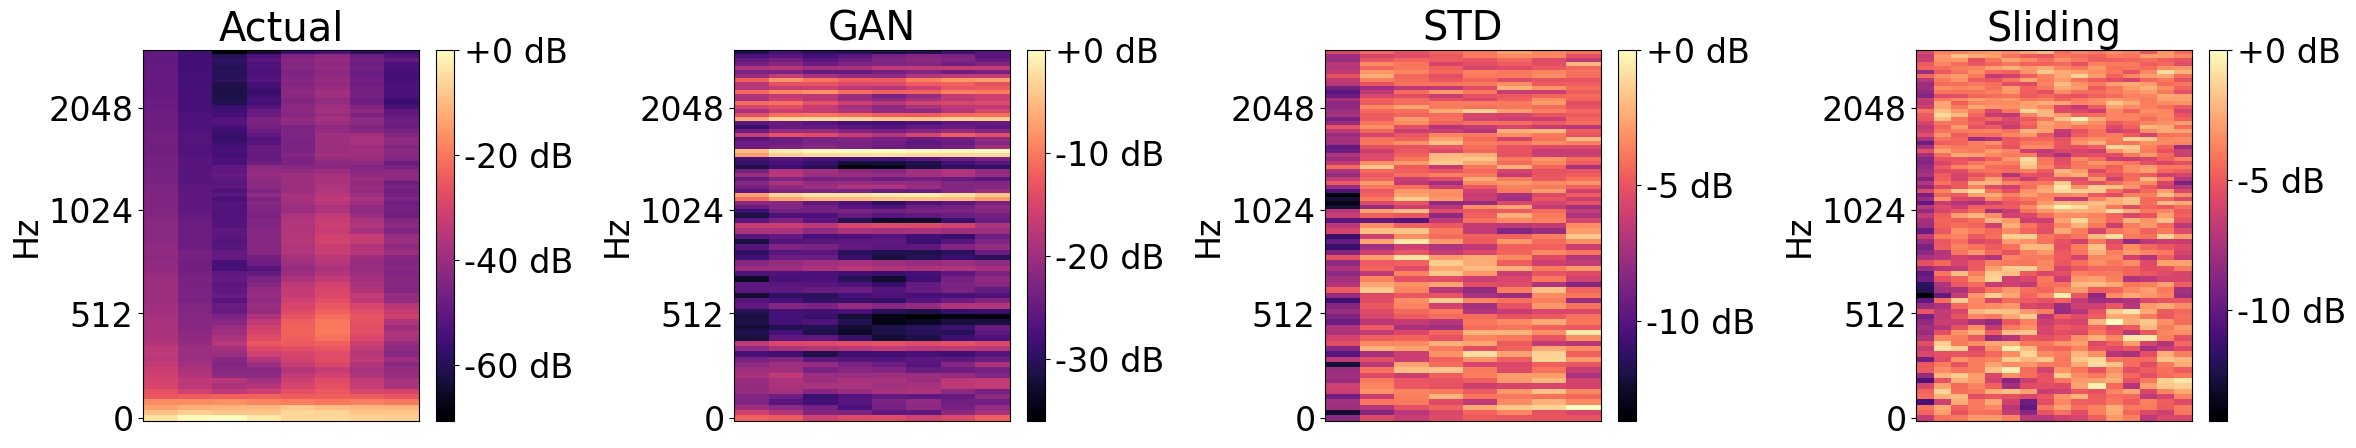

In [58]:
plot_melspectrograms(
    waveforms["actual"], waveforms["gan"], waveforms["std"], waveforms["sliding"],  
    titles=["Actual", "GAN", "STD", "Sliding"],
    sr=6000
)

In [345]:
waveforms["gan"].max(), waveforms["std"].max(), waveforms["sliding"].max()

(np.float32(0.97669536), np.float32(0.85298896), np.float32(0.84381956))

In [341]:
from IPython.display import Audio, display

print(speaker_ids[248])
display(Audio(data=best_generated[248][0], rate=6000))
display(Audio(
    data=extract_waveform("/home/desild/work/academic/sem3/TrustworthyML-assignment/tacotron2/vctk/inverted_samples/white_noise_tanh/3/1/inverted_sample_std.pt")
    , rate = 6000))
display(Audio(
    data=extract_waveform("/home/desild/work/academic/sem3/TrustworthyML-assignment/tacotron2/vctk/inverted_samples/white_noise_tanh/3/1/inverted_sample_sliding.pt")
    , rate = 6000))

3
